In [1]:
from Environment import Ecosystem
import plotly.graph_objects as go
import numpy as np
from Utils import hsv2rgb

pygame-ce 2.5.1 (SDL 2.30.6, Python 3.11.9)


In [2]:
default_params = {
    "mapsize": 800,
    "min_depth": 10,
    "max_depth": 70,
    "starting_population": 15,
    "food_value": 200,
    "movement_cost": -1,
    "food_per_agent": 2,
    "max_timesteps": 200000,
    "movement_cost_factor": 0.025,
    "egg_incubation_time": 100,
    "mutation_factor": 2,
    "starting_plant_population": 100,
    "plant_growth_speed": 0.01,
    "plant_minimum_growth_percentage": 0.5,
    "plant_spread_amount": 6,
    "plant_spread_radius": 800,
    "plant_spread_interval": 50,
    "max_plants_global": 200,
}

default_species = {
    "hb1": {
        "name": "generic herbivore",
        "type": "herbivore",
        "population": 50,
        "color": 90,
        "rgb": hsv2rgb(90, 1, 1),
        "genome": {
            "speed": {"min": 1.0, "max": 6.0},
            "health": {"min": 170.0, "max": 340.0},
            "stomach_size": {"min": 100.0, "max": 150.0},  # Moderate stomach size
            "armor": {"min": 0.0, "max": 5.0},  # Relatively low armor
            "bite_damage": {"min": 5.0, "max": 20.0},  # Low bite damage for herbivores
            "eyesight_range": {"min": 30.0, "max": 80.0},  # Moderate eyesight
            "feed_range": {"min": 3.0, "max": 4.0},  # Moderate feeding range
            "bite_range": {"min": 2.0, "max": 3.0},  # Moderate bite range
            "memory": {"min": 15, "max": 25},  # Moderate memory
            "depth_tolerance_range": {"min": 10, "max": 15},  # Moderate depth tolerance
            "lifespan": 2000,
            "egg_lifespan_required": 0.1,
        }
    },
    "cv1": {
        "name": "generic carnivore",
        "type": "carnivore",
        "population": 30,
        "color": 0,
        "rgb": hsv2rgb(0, 1, 1),
        "genome": {
            "speed": {"min": 2.0, "max": 8.0},  # Carnivores generally faster
            "health": {"min": 60.0, "max": 110.0},
            "stomach_size": {"min": 80.0, "max": 120.0},  # Moderate stomach size
            "armor": {"min": 2.0, "max": 7.0},  # Moderate armor
            "bite_damage": {"min": 40.0, "max": 90.0},  # Higher bite damage for carnivores
            "eyesight_range": {"min": 10.0, "max": 50.0},  # Good eyesight
            "feed_range": {"min": 2.0, "max": 3.0},  # Moderate feeding range
            "bite_range": {"min": 2.0, "max": 4.0},  # Moderate bite range
            "memory": {"min": 10, "max": 20},  # Moderate memory
            "depth_tolerance_range": {"min": 15, "max": 35},  # Moderate depth tolerance
            "lifespan": 2000,
            "egg_lifespan_required": 0.2,
        }
    },
    # "n_p": {
    #     "name": "Nile Perch",
    #     "type": "carnivore",
    #     "population": 10,
    #     "color": 150,
    #     "rgb": hsv2rgb(150, 1, 1),
    #     "genome": {
    #         "speed": {"min": 3.0, "max": 10.0},
    #         "health": {"min": 580.0, "max": 1150.0},
    #         "stomach_size": {"min": 120.0, "max": 200.0},
    #         "armor": {"min": 5.0, "max": 10.0},
    #         "bite_damage": {"min": 40.0, "max": 70.0},
    #         "eyesight_range": {"min": 30.0, "max": 70.0},
    #         "feed_range": {"min": 1.0, "max": 2.0},
    #         "bite_range": {"min": 3.0, "max": 5.0},
    #         "memory": {"min": 20, "max": 30},
    #         "depth_tolerance_range": {"min": 0, "max": 50},
    #         "lifespan": 12000,
    #     }
    # },
}

for name, species in default_species.items():
  print(species["rgb"])

(0, 255, 255)
(255, 0, 0)


In [3]:
env = Ecosystem("human", params=default_params, species=default_species, debug=False)
env.reset()
try:
    while not env.finished:
        env.stepper()
except KeyboardInterrupt:
    env.close()

Parameter max_plants_global is invalid
[[69 69 69 ... 62 62 62]
 [69 69 69 ... 62 62 62]
 [69 69 69 ... 62 62 62]
 ...
 [52 52 52 ... 10 10 10]
 [52 52 52 ... 10 10 10]
 [52 52 52 ... 10 10 10]]
Closing environment Ecosystem at 754 timestep.


In [4]:
def analyze_agent_lifecycle(env):
    """
    Lists each agent and analyzes:
      - Final cause of death (if any)
      - Breeding conditions at the end of life (or end of simulation)
    
    Returns:
      A list of dictionaries, one per agent, with keys:
        {
          "agent_name": str,
          "death_cause": str,
          "death_timestep": int or None,
          "final_timestep": int,
          "final_health": float,
          "final_food": float,
          "breeding_eligible": bool
        }
    """
    results = []
    
    # Build a set of all agents that ever existed
    # (some may still be alive, some may be in death_log).
    all_agents_ever = set(env.death_log.keys()) | set(env.agentNames)
    
    # For each agent, find the last timestep it appeared in agent_history
    for agent_name in sorted(all_agents_ever):
        final_timestep = None
        final_agent_data = None
        
        # Walk backwards through agent_history until we find the agent
        for t in reversed(range(len(env.agent_history))):
            if agent_name in env.agent_history[t]:
                final_timestep = t
                final_agent_data = env.agent_history[t][agent_name]
                break
        
        if final_timestep is None:
            # Possibly this agent never even made it into agent_history?
            # e.g., if it died upon creation. We'll skip or mark unknown
            results.append({
                "agent_name": agent_name,
                "death_cause": "never appeared",
                "death_timestep": None,
                "final_timestep": None,
                "final_health": None,
                "final_food": None,
                "breeding_eligible": False
            })
            continue
        
        # Get cause/time of death if present
        death_info = env.death_log.get(agent_name, None)
        if death_info:
            death_cause = death_info["reason"]
            death_time = death_info["time"]
        else:
            death_cause = "alive"
            death_time = None
            
        final_health = final_agent_data.health
        final_food = final_agent_data.food
        
        egg_ok = (final_agent_data.egg_permitted >= final_agent_data.lifespan * 0.3)
        food_ok = (final_food >= final_agent_data.stomach_size / 2)
        breeding_eligible = (egg_ok and food_ok)
        
        results.append({
            "agent_name": agent_name,
            "death_cause": death_cause,
            "depth": final_agent_data.depth,
            "depth_min": final_agent_data.stats["depth_point"] - final_agent_data.stats["depth_tolerance_range"],
            "depth_max": final_agent_data.stats["depth_point"] + final_agent_data.stats["depth_tolerance_range"],
            "death_timestep": death_time,
            "final_timestep": final_timestep,
            "final_health": final_health,
            "final_food": final_food,
            "breeding_eligible": breeding_eligible,
            "egg_ok": [egg_ok, final_agent_data.egg_permitted, final_agent_data.lifespan * 0.3],
            "food_ok": food_ok,
        })
    
    return results


In [5]:
report = analyze_agent_lifecycle(env)
for row in report:
    if row["death_cause"] != "starved":
        for key, value in row.items():
            print(key, value)
        print('\n')


agent_name cv1_agent_1
death_cause alive
depth 11.243333381967538
depth_min 20.094677076249898
depth_max 56.50210135750662
death_timestep None
final_timestep 753
final_health 80.85447124647467
final_food 80.80919790719649
breeding_eligible False
egg_ok [False, 11, 510.9143547649388]
food_ok True


agent_name cv1_agent_1-cv1_agent_11-child_743
death_cause alive
depth 45.837817466804
depth_min -16.134452269026138
depth_max 62.9950920158346
death_timestep None
final_timestep 753
final_health 62.731374242412606
final_food 79.74011007252597
breeding_eligible False
egg_ok [False, 10, 665.0641561711324]
food_ok True


agent_name cv1_agent_1-cv1_agent_22-cv1_agent_28-cv1_agent_6-child_159-cv1_agent_17-cv1_agent_3-child_135-child_283-child_429-child_556
death_cause alive
depth 38.686724572011656
depth_min 23.026001896335224
depth_max 132.84901711742248
death_timestep None
final_timestep 753
final_health 76.81869982648098
final_food 224.8088763065387
breeding_eligible False
egg_ok [False, 197, 6

In [11]:
import plotly.graph_objects as go

def agent_stat_value(agent, stat_key):
    """
    Safely returns a numeric value for the specified stat_key in an agent.
    Defaults to 0 if the agent doesn't have that attribute.
    """
    if hasattr(agent, stat_key):
        return getattr(agent, stat_key)
    return agent.stats.get(stat_key, 0.0)


def rolling_average(series, window=1):
    """
    Computes a simple rolling average of 'series' using the specified 'window' size.
    If window <= 1, returns the original series (no smoothing).
    """
    if window <= 1:
        return series
    
    smoothed = []
    for i in range(len(series)):
        start_idx = max(0, i - window + 1)
        subset = series[start_idx : i + 1]
        smoothed.append(sum(subset) / len(subset))
    return smoothed


def plot_parameter_over_time(
    env, 
    parameter="population",
    mode="species",
    use_log_scale=False,
    smoothing_window=1,
    use_percentage=False,
    plant_scale_divisor=1.0
):
    """
    Plots a chosen parameter (or multiple) of the environment over time using Plotly,
    all on a SINGLE plot.

    Features:
      - 'all' => plot multiple numeric attributes in one figure
      - 'population' => plot agent population (plus scaled plant pop) in one figure
      - or a single stat => e.g. "movement_cost", "speed", "memory", etc.
      - optional rolling average smoothing
      - either absolute values or % change from (smoothed) baseline
      - optional log scale for population
      - plant population can be scaled by 'plant_scale_divisor'

    Args:
        env: The Ecosystem environment instance (with .agent_history & .plant_history).
        parameter (str):
            - "population" => agent pop + scaled plant pop
            - "all"        => multiple numeric attributes
            - or a single numeric stat name
        mode (str): "species" or "total"
        use_log_scale (bool): if True & parameter=="population", log scale on Y
        smoothing_window (int): rolling average window
        use_percentage (bool): if True, lines show % change from first smoothed value
                               else show the raw/smoothed absolute values
        plant_scale_divisor (float): scale factor for plant population (e.g. 10.0 => plant_count/10)

    Returns:
        plotly.graph_objects.Figure
    """
    import numpy as np

    # Time dimension
    num_timesteps = len(env.agent_history)
    if num_timesteps == 0:
        raise ValueError("No recorded history in env.agent_history.")
    timesteps = list(range(num_timesteps))

    # Helper to convert raw values -> percent from first
    def pct_change_from_first(values):
        if not values:
            return []
        first_val = values[0]
        if first_val == 0:
            return [0] * len(values)
        return [((v - first_val) / first_val) * 100 for v in values]

    # -----------------------------------------------------------
    # "all": multiple numeric stats on one single figure
    # -----------------------------------------------------------
    if parameter == "all":
        # Choose numeric stats to display
        numeric_stats = [
            "speed", "armor", "memory", "movement_cost",
            "health", "stomach_size", "bite_damage", "eyesight_range",
            "feed_range", "bite_range"
        ]
        fig = go.Figure()

        if mode == "species":
            dash_styles = ["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]
            for s in env.species.keys():
                rgb = env.species[s]["rgb"]
                dash_index = 0
                for attr in numeric_stats:
                    # 1) gather raw average data
                    raw_values = []
                    for t in range(num_timesteps):
                        agents_t = env.agent_history[t]
                        sum_s, count_s = 0.0, 0
                        for ag in agents_t.values():
                            if ag.stats["species"] == s:
                                sum_s += agent_stat_value(ag, attr)
                                count_s += 1
                        avg_s = sum_s / count_s if count_s else 0
                        raw_values.append(avg_s)

                    # 2) apply smoothing
                    smoothed = rolling_average(raw_values, smoothing_window)

                    # 3) if use_percentage => convert to %
                    if use_percentage:
                        data_plot = pct_change_from_first(smoothed)
                    else:
                        data_plot = smoothed

                    fig.add_trace(
                        go.Scatter(
                            x=timesteps,
                            y=data_plot,
                            mode='lines',
                            line=dict(
                                color=f"rgb({rgb[0]},{rgb[1]},{rgb[2]})",
                                dash=dash_styles[dash_index % len(dash_styles)]
                            ),
                            name=f"{s}-{attr}"
                        )
                    )
                    dash_index += 1

        else:
            # mode="total": single line per attribute across all agents
            color_palette = [
                "rgb(255,0,0)", "rgb(0,255,0)", "rgb(0,0,255)",
                "rgb(255,165,0)", "rgb(255,0,255)", "rgb(128,0,128)",
                "rgb(0,128,128)", "rgb(128,128,0)", "rgb(70,70,70)", "rgb(0,0,0)"
            ]
            for i, attr in enumerate(numeric_stats):
                raw_values = []
                for t in range(num_timesteps):
                    agents_t = env.agent_history[t]
                    s_val, c_val = 0.0, 0
                    for ag in agents_t.values():
                        s_val += agent_stat_value(ag, attr)
                        c_val += 1
                    avg_val = s_val / c_val if c_val else 0
                    raw_values.append(avg_val)

                smoothed = rolling_average(raw_values, smoothing_window)
                data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed
                color_ = color_palette[i % len(color_palette)]

                fig.add_trace(
                    go.Scatter(
                        x=timesteps,
                        y=data_plot,
                        mode='lines',
                        line=dict(color=color_),
                        name=f"All-{attr}"
                    )
                )

        title_str = "All Attributes"
        if use_percentage:
            title_str += " (% Change)"
        else:
            title_str += " (Absolute)"
        fig.update_layout(
            title=f"{title_str} Over Time (mode={mode})",
            xaxis_title="Timestep",
            yaxis_title="Value" if not use_percentage else "% Change from T=0"
        )
        return fig

    # -----------------------------------------------------------
    # "population": agent pop (+ scaled plant pop) in one figure
    # -----------------------------------------------------------
    if parameter == "population":
        fig = go.Figure()

        # gather plant counts
        plant_counts = []
        if hasattr(env, 'plant_history'):
            for t in range(num_timesteps):
                plant_counts.append(len(env.plant_history[t]))
        else:
            plant_counts = [0]*num_timesteps

        # scale them
        if plant_scale_divisor != 1.0:
            plant_counts = [pc / plant_scale_divisor for pc in plant_counts]

        if mode == "species":
            for s in env.species.keys():
                rgb = env.species[s]["rgb"]
                raw_vals = []
                for t in range(num_timesteps):
                    agents_t = env.agent_history[t]
                    c_ = sum(1 for ag in agents_t.values() if ag.stats["species"] == s)
                    raw_vals.append(c_)

                smoothed = rolling_average(raw_vals, smoothing_window)
                data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

                fig.add_trace(
                    go.Scatter(
                        x=timesteps,
                        y=data_plot,
                        mode='lines',
                        line=dict(color=f"rgb({rgb[0]},{rgb[1]},{rgb[2]})"),
                        name=f"{s} population"
                    )
                )
            # plants
            smoothed_plants = rolling_average(plant_counts, smoothing_window)
            plant_plot = pct_change_from_first(smoothed_plants) if use_percentage else smoothed_plants
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=plant_plot,
                    mode='lines',
                    line=dict(color="rgb(0,255,0)"),
                    name=f"Plant population (/ {plant_scale_divisor})"
                )
            )
        else:
            # total
            agent_raw = []
            for t in range(num_timesteps):
                agents_t = env.agent_history[t]
                agent_raw.append(len(agents_t))

            smoothed_agents = rolling_average(agent_raw, smoothing_window)
            agent_plot = pct_change_from_first(smoothed_agents) if use_percentage else smoothed_agents
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=agent_plot,
                    mode='lines',
                    line=dict(color="rgb(0,0,0)"),
                    name="All Agents population"
                )
            )

            smoothed_plants = rolling_average(plant_counts, smoothing_window)
            plant_plot = pct_change_from_first(smoothed_plants) if use_percentage else smoothed_plants
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=plant_plot,
                    mode='lines',
                    line=dict(color="rgb(0,255,0)"),
                    name=f"Plant population (/ {plant_scale_divisor})"
                )
            )

        pop_title = "Population"
        if use_percentage:
            pop_title += " (% Change)"
        else:
            pop_title += " (Absolute)"

        fig.update_layout(
            title=f"{pop_title} Over Time",
            xaxis_title="Timestep",
            yaxis_title="Count" if not use_percentage else "% Change from T=0"
        )
        if use_log_scale:
            fig.update_yaxes(type="log")
        return fig

    # -----------------------------------------------------------
    # Otherwise, a single numeric stat
    # -----------------------------------------------------------
    fig = go.Figure()

    if mode == "species":
        for s in env.species.keys():
            rgb = env.species[s]["rgb"]
            raw_vals = []
            for t in range(num_timesteps):
                agents_t = env.agent_history[t]
                sum_s_, count_s_ = 0.0, 0
                for ag in agents_t.values():
                    if ag.stats["species"] == s:
                        sum_s_ += agent_stat_value(ag, parameter)
                        count_s_ += 1
                avg_ = sum_s_ / count_s_ if count_s_ else 0
                raw_vals.append(avg_)

            smoothed = rolling_average(raw_vals, smoothing_window)
            data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=data_plot,
                    mode='lines',
                    line=dict(color=f"rgb({rgb[0]},{rgb[1]},{rgb[2]})"),
                    name=f"{s} ({parameter})"
                )
            )
    else:
        # total
        raw_vals = []
        for t in range(num_timesteps):
            agents_t = env.agent_history[t]
            sum_, count_ = 0.0, 0
            for ag in agents_t.values():
                sum_ += agent_stat_value(ag, parameter)
                count_ += 1
            avg_ = sum_ / count_ if count_ else 0
            raw_vals.append(avg_)

        smoothed = rolling_average(raw_vals, smoothing_window)
        data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

        fig.add_trace(
            go.Scatter(
                x=timesteps,
                y=data_plot,
                mode='lines',
                line=dict(color="rgb(0,0,0)"),
                name=f"All Agents ({parameter})"
            )
        )

    # Final labeling
    if use_percentage:
        title_str = f"{parameter.capitalize()} % Change Over Time"
        y_label_str = "% Change from T=0"
    else:
        title_str = f"{parameter.capitalize()} (Absolute) Over Time"
        y_label_str = f"{parameter.capitalize()}"

    fig.update_layout(
        title=title_str,
        xaxis_title="Timestep",
        yaxis_title=y_label_str
    )
    return fig


In [12]:
# Once the simulation completes, call the plotting function:
fig = plot_parameter_over_time(env, parameter="population", mode="species", use_log_scale=True, smoothing_window=5, plant_scale_divisor=3)
fig.show()  # or pio.show(fig)

fig2 = plot_parameter_over_time(env, parameter="movement_cost", mode="total", smoothing_window=5)
fig2.show()

fig3 = plot_parameter_over_time(env, parameter="all", mode="total", smoothing_window=5, use_percentage=True, use_log_scale=True)
fig3.show()

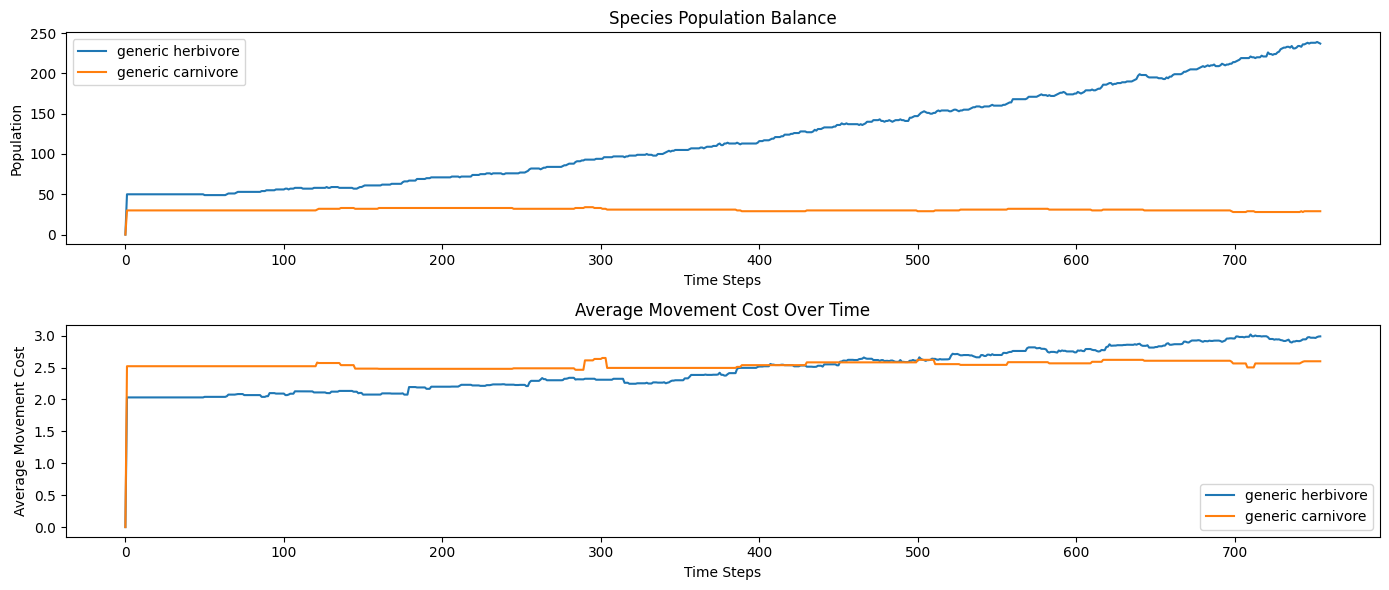

In [8]:
import matplotlib.pyplot as plt

# Assuming env.full_population_history is a dictionary where:
# - keys are species names
# - values are lists of tuples (population, average_movement_cost)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(14, 6))

# Plot population size
for species, history in env.full_population_history.items():
    population_history = [pop for pop, _ in history]  # Extract population values
    ax1.plot(population_history, label=env.species[species]["name"])

ax1.set_title("Species Population Balance")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Population")
ax1.legend()

# Plot average movement cost
for species, history in env.full_population_history.items():
    movement_cost_history = [-cost for _, cost in history]  # Extract movement cost values
    ax2.plot(movement_cost_history, label=env.species[species]["name"])

ax2.set_title("Average Movement Cost Over Time")
ax2.set_xlabel("Time Steps")
ax2.set_ylabel("Average Movement Cost")
ax2.legend()

plt.tight_layout()
plt.show()

C:\Users\creep\AppData\Local\Temp\ipykernel_27728\3857098510.py:68: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\creep\AppData\Local\Temp\ipykernel_27728\3857098510.py:71: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\creep\AppData\Local\Temp\ipykernel_27728\3857098510.py:74: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



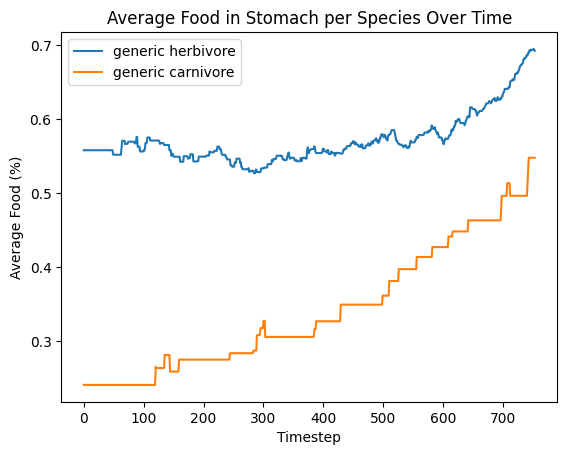

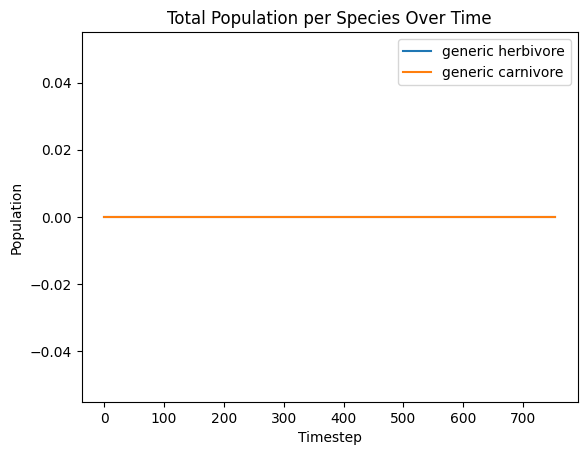

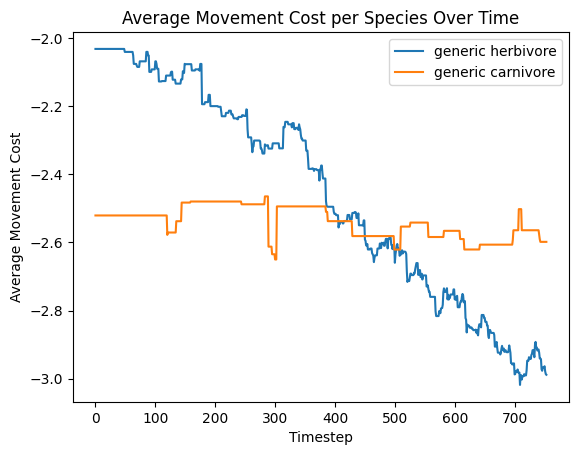

In [9]:
import matplotlib.pyplot as plt

def analyze_environment(env, parameter):
    """
    Analyzes the environment and creates a line graph based on the specified parameter.

    Args:
        env: The environment object.
        parameter: The parameter to analyze ("average_food", "population_total", "movement_cost").

    Returns:
        A matplotlib figure object.
    """

    if parameter not in ["average_food", "population_total", "movement_cost"]:
        raise ValueError("Invalid parameter. Choose from: 'average_food', 'population_total', 'movement_cost'")

    # Initialize data structures
    timesteps = range(len(env.agent_history))
    species_data = {species: [] for species in env.species.keys()}

    # Calculate average data for each species at each timestep
    for timestep, agents_at_timestep in enumerate(env.agent_history):
        species_counts = {s: 0 for s in env.species.keys()}
        species_averages = {s: 0 for s in env.species.keys()}  # Store averages for each species

        for agent_name, agent in agents_at_timestep.items():
            species = agent.stats["species"]
            species_counts[species] += 1

            if parameter == "average_food":
                species_averages[species] += agent.food / agent.stomach_size
            elif parameter == "movement_cost":
                species_averages[species] += agent.movement_cost

        # Calculate averages for each species at this timestep
        for species, count in species_counts.items():
            if count > 0:
                if parameter == "average_food":
                    species_averages[species] /= count 
                elif parameter == "movement_cost":
                    species_averages[species] /= count

            species_data[species].append(species_averages[species])

    # Create the plot
    fig, ax = plt.subplots()
    for species, data in species_data.items():
        ax.plot(timesteps, data, label=env.species[species]["name"])

    # Set plot labels and title
    if parameter == "average_food":
        ax.set_ylabel("Average Food (%)")
        ax.set_title("Average Food in Stomach per Species Over Time")
    elif parameter == "population_total":
        ax.set_ylabel("Population")
        ax.set_title("Total Population per Species Over Time")
    elif parameter == "movement_cost":
        ax.set_ylabel("Average Movement Cost")
        ax.set_title("Average Movement Cost per Species Over Time")

    ax.set_xlabel("Timestep")
    ax.legend()
    return fig

# Example usage:
fig_food = analyze_environment(env, "average_food")
fig_food.show() 

fig_population = analyze_environment(env, "population_total")
fig_population.show()

fig_cost = analyze_environment(env, "movement_cost")
fig_cost.show()

In [10]:
x = env.close()

Closing environment Ecosystem at 754 timestep.
